In [41]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal
from audiostretchy.stretch import stretch_audio
import pandas as pd
import seaborn as sns
import os

# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

## audio, labels, speech recognition

0 i ------------------- from 0.3000 to 0.4200 sec, confidence: 100.00%
1 skymningen ---------- from 0.4200 to 1.2600 sec, confidence: 100.00%
2 en ------------------ from 1.3500 to 1.5000 sec, confidence: 100.00%
3 mycket -------------- from 1.5000 to 1.8000 sec, confidence: 100.00%
4 het ----------------- from 1.8300 to 2.1000 sec, confidence: 100.00%
5 dag ----------------- from 2.1000 to 2.4300 sec, confidence: 100.00%
6 i ------------------- from 2.4300 to 2.5200 sec, confidence: 100.00%
7 början -------------- from 2.5200 to 2.7900 sec, confidence: 100.00%
8 av ------------------ from 2.7900 to 2.9100 sec, confidence: 100.00%
9 juli ---------------- from 2.9100 to 3.3600 sec, confidence: 100.00%
10 lämnade ------------- from 3.3600 to 3.9900 sec, confidence: 100.00%
11 en ------------------ from 3.9900 to 4.1400 sec, confidence: 100.00%
12 ung ----------------- from 4.1400 to 4.4100 sec, confidence: 100.00%
13 man ----------------- from 4.4100 to 4.6800 sec, confidence: 100.00%
14

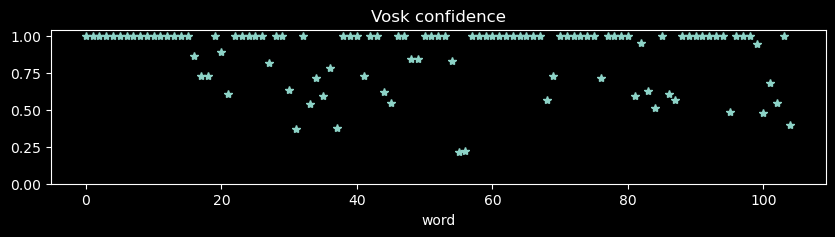

In [42]:
labels_path = (
    "example_speech_Andreas/180923214834-Y20UOTIE-text-000_vowels_timestamp_manual.csv"
)
# labels_path = "wav_examples/digitala_vowels_manual_timestamps.csv"

labels_df = pd.read_csv(labels_path)
audio_path = "audio_preproc/180923214834-Y20UOTIE-text-000_pp.wav"
# audio_path = "wav_examples/digitala_resurser_sv.wav"
# audio_path = "audio_preproc/digitala_trash2_pp.wav"

Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"

if "model" not in locals():
    model = Model(model_path)

words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])

# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

In [43]:
reload(tools)
add_context = False
fl = int(0.03 * Fs)
grouped_frames = tools.extract_vowels(
    words,
    audio,
    Fs,
    fl,
    add_context=False,
    long_frame=True,
    zero_pad=True,
)

vowels_in_text = {v: 0 for v in tools.VOWELS_SV}
for c in tools.checkVowels(text, tools.VOWELS_SV):
    vowels_in_text[c] += 1


print("found vowels:")
for v in grouped_frames.keys():
    print(
        "    ",
        v,
        len(grouped_frames[v]["frame"]),
        str(round(100 * len(grouped_frames[v]["frame"]) / max(vowels_in_text[v], 1), 3))
        + "%",
    )

print("total: vowels in text", sum([vowels_in_text[v] for v in vowels_in_text.keys()]))
for v in vowels_in_text.keys():
    print(vowels_in_text[v])

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:587: RuntimeWarning: invalid value encountered in divide
  r_x /= r_x[ 0 ]


found vowels:
     e 10 26.316%
     y 0 0.0%
     u 2 20.0%
     i 4 17.391%
     o 5 29.412%
     å 0 0.0%
     a 12 25.532%
     ö 1 11.111%
     ä 3 42.857%
total: vowels in text 164
38
5
10
23
17
8
47
9
7


In [44]:
reload(tools)
p, r, error_words = tools.score_vs_labels(
    grouped_frames, labels_df, accept_partial=True
)

id = os.path.split(audio_path)[-1][:-4]
tools.groupedframes_to_files(
    grouped_frames, Fs, id, clear_folder=True, metadata={"origin_file": audio_path}
)

Classification errors:
- at 1.44s: MISS classed as e, word: en
- at 3.45s: MISS classed as ä, word: lämnade
- at 3.63s: MISS classed as a, word: lämnade
- at 4.08s: MISS classed as e, word: en
- at 4.92s: MISS classed as a, word: kammare
- at 5.19s: MISS classed as a, word: kammare
- at 6.51s: MISS classed as i, word: vid
- at 19.5s: MISS classed as u, word: under
- at 19.86s: MISS classed as e, word: den
- at 19.98s: MISS classed as ö, word: höga
- at 20.16s: MISS classed as a, word: höga
- at 25.14s: MISS classed as a, word: bostad
- at 27.33s: MISS classed as i, word: värdinnan
- at 27.54s: MISS classed as a, word: värdinnan
- at 28.98s: MISS classed as i, word: vind
- at 32.88854875283447s: MISS classed as e, word: med
- at 35.65238095238095s: MISS classed as e, word: en
- at 43.38s: MISS classed as a, word: alltid
------------------------------
precision: 51.351% (19/37)
recall: 16.522% (19/115)


## Error analysis

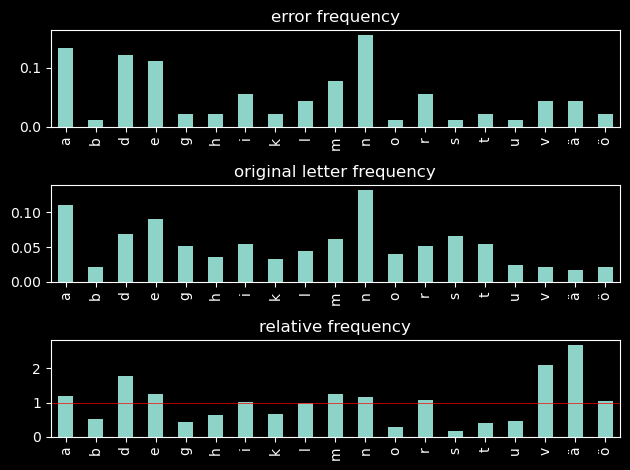

In [45]:
error_letters = list("".join(error_words))

all_letters = [x for x in list("".join(text.split())) if x in error_letters]
error_counts = (
    pd.Series(error_letters).sort_values().value_counts(normalize=True, sort=False)
)
all_counts = (
    pd.Series(all_letters).sort_values().value_counts(normalize=True, sort=False)
)
error_ratio = error_counts / all_counts

plt.figure()
plt.subplot(311)
error_counts.plot(kind="bar")
plt.title("error frequency")
plt.subplot(312)
all_counts.plot(kind="bar")
plt.title("original letter frequency")
plt.subplot(313)
error_ratio.plot(kind="bar")
plt.title("relative frequency")
plt.axhline(1, color="r")
plt.tight_layout()
plt.show()

## plot result

total found vowels: 37
unique start points: 37
unique stop points: 37


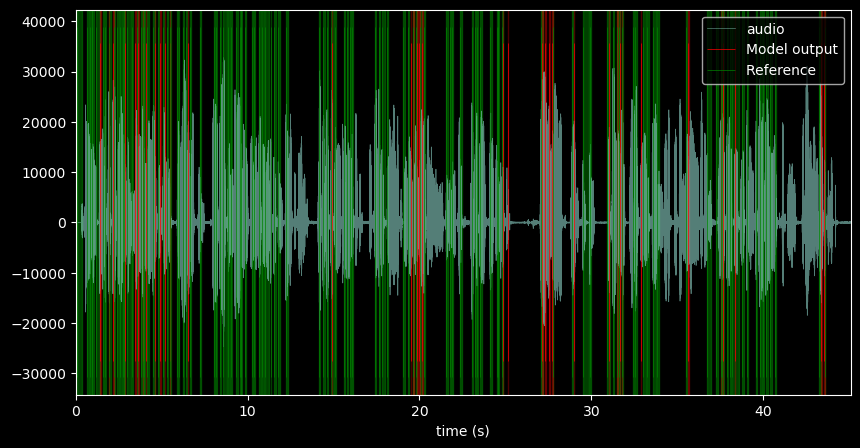

In [46]:
starts_all, stops_all, _, _ = tools.groupedframes_to_lists(grouped_frames)

plt.figure(figsize=(10, 5))
tools.plot_intervals(audio, starts_all, stops_all, labels_df, Fs)
tr = (0, len(audio) / Fs)
# tr = (0, 2)

plt.xlim(*tr)
plt.legend(loc="upper right")
plt.show()

In [47]:
print(len(audio) / Fs, "seconds")

45.09315192743764 seconds


In [48]:
display(labels_df)

,vowel,tmin,tmax
0,i,0.10,0.35
1,y,0.65,0.75
2,i,0.85,0.95
3,e,0.95,1.05
4,e,1.20,1.40
...,...,...,...
110,ä,40.16,40.28
111,i,40.42,40.50
112,a,40.66,40.75
113,a,43.25,43.37


In [49]:
for i in range(len(labels_df["tmin"]) - 1):
    if labels_df["tmax"][i] > labels_df["tmin"][i + 1]:
        print(labels_df.iloc[i])

# Optimize

In [50]:
precision = {}
recall = {}

## Optimize volume

In [51]:
    fl = int(0.02 * Fs)
    volume = np.linspace(5, 75, 20)
    precision["volume"] = []
    recall["volume"] = []
    for v in range(len(volume)):
        grouped_frames = tools.extract_vowels(
            words,
            audio,
            Fs,
            fl,
            add_context=False,
            long_frame=True,
            vol_thr=volume[v],
            print_info=False,
        )
        starts_all, stops_all, vowels_all = tools.groupedframes_to_lists(
            grouped_frames, print_info=False
        )
        p, r = tools.score_vs_labels(
            starts_all,
            stops_all,
            labels_df,
            vowels=vowels_all,
            accept_partial=True,
            print_info=False,
        )
        precision["volume"].append(p)
        recall["volume"].append(r)

    plt.figure(figsize=(10, 5))
    plt.plot(volume, precision["volume"])
    plt.plot(volume, recall["volume"])
    plt.legend(("Precision", "Recall"))
    plt.xlabel("Volume treshold")

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )


ValueError: too many values to unpack (expected 3)

## Optimize zero threshold

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-pac

Text(0.5, 0, 'Zero treshold')

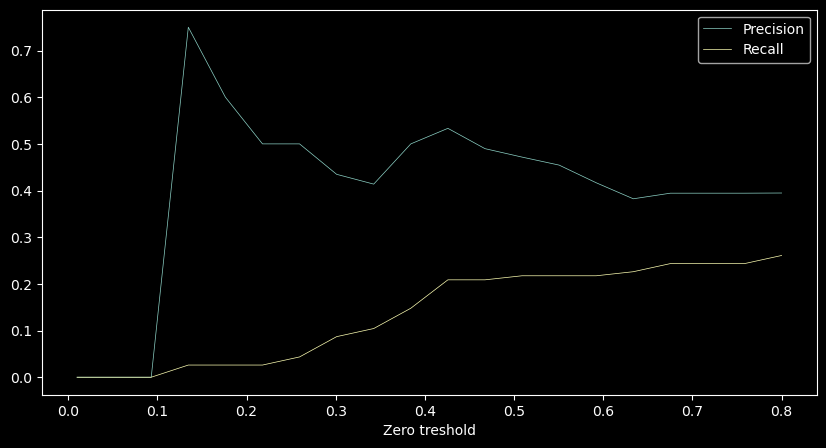

In [ ]:
fl = int(0.02 * Fs)
zero = np.linspace(0.01, 0.8, 20)
precision["zero"] = []
recall["zero"] = []
for v in range(len(volume)):
    grouped_frames = tools.extract_vowels(
        words,
        audio,
        Fs,
        fl,
        add_context=False,
        long_frame=True,
        vol_thr=50,
        print_info=False,
        zero_thr=zero[v],
    )
    starts_all, stops_all, vowels_all = tools.groupedframes_to_lists(
        grouped_frames, print_info=False
    )
    p, r = tools.score_vs_labels(
        starts_all,
        stops_all,
        labels_df,
        vowels=vowels_all,
        accept_partial=True,
        print_info=False,
    )
    precision["zero"].append(p)
    recall["zero"].append(r)

plt.figure(figsize=(10, 5))
plt.plot(zero, precision["zero"])
plt.plot(zero, recall["zero"])
plt.legend(("Precision", "Recall"))
plt.xlabel("Zero treshold")

## Optimize frame length

In [ ]:
frame_length = np.int32(np.linspace(0.01, 0.1, 20) * Fs)
precision["fl"] = []
recall["fl"] = []
for v in range(len(volume)):
    grouped_frames = tools.extract_vowels(
        words,
        audio,
        Fs,
        fl=frame_length[v],
        add_context=False,
        long_frame=True,
        vol_thr=50,
        print_info=False,
        zero_thr=0.3,
    )
    starts_all, stops_all, vowels_all = tools.groupedframes_to_lists(
        grouped_frames, print_info=False
    )
    p, r = tools.score_vs_labels(
        starts_all,
        stops_all,
        labels_df,
        vowels=vowels_all,
        accept_partial=True,
        print_info=False,
    )
    precision["fl"].append(p)
    recall["fl"].append(r)

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: divide by zero encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\peakutils\peak.py:43: RuntimeWarning: invalid value encountered in scalar add
  thres = thres * (np.max(y) - np.min(y)) + np.min(y)
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(frame_length / Fs, precision["fl"])
plt.plot(frame_length / Fs, recall["fl"])
plt.legend(("Precision", "Recall"))
plt.xlabel("Frame length [s]")

NameError: name 'frame_length' is not defined

<Figure size 1000x500 with 0 Axes>

## Optimize white noise

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:587: RuntimeWarning: invalid value encountered in divide
  r_x /= r_x[ 0 ]
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:587: RuntimeWarning: invalid value encountered in divide
  r_x /= r_x[ 0 ]
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: Runti

Text(0.5, 0, 'White threshold')

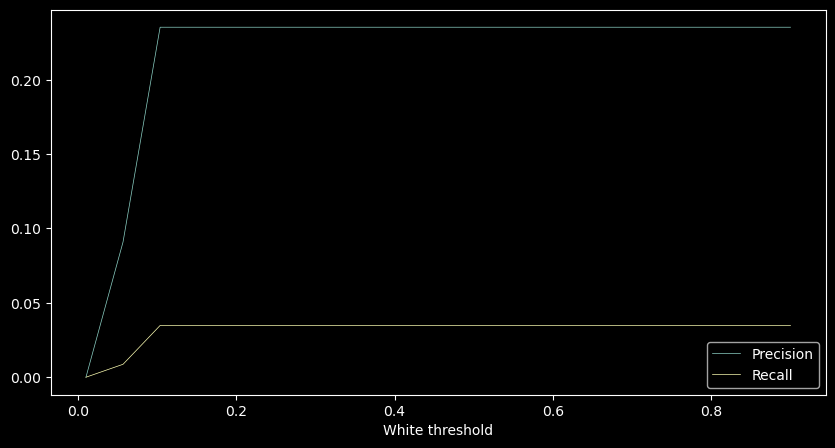

In [ ]:
white = np.linspace(0.01, 0.9, 20)
precision["white"] = []
recall["white"] = []
for v in range(len(volume)):
    grouped_frames = tools.extract_vowels(
        words,
        audio,
        Fs,
        fl=int(0.03 * Fs),
        add_context=False,
        long_frame=True,
        vol_thr=50,
        print_info=False,
        zero_thr=0.3,
        white_thr=white[v],
    )
    starts_all, stops_all, vowels_all = tools.groupedframes_to_lists(
        grouped_frames, print_info=False
    )
    p, r = tools.score_vs_labels(
        starts_all,
        stops_all,
        labels_df,
        vowels=vowels_all,
        accept_partial=True,
        print_info=False,
    )
    precision["white"].append(p)
    recall["white"].append(r)

plt.figure(figsize=(10, 5))
plt.plot(white, precision["white"])
plt.plot(white, recall["white"])
plt.legend(("Precision", "Recall"))
plt.xlabel("White threshold")

## optimize peak height

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:587: RuntimeWarning: invalid value encountered in divide
  r_x /= r_x[ 0 ]
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-pac

Text(0.5, 0, 'Height factor')

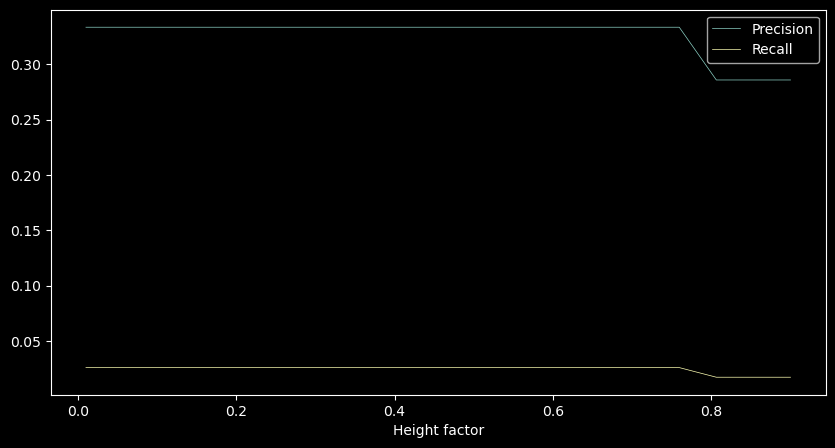

In [ ]:
reload(tools)
height = np.linspace(0.01, 0.9, 20)
precision["height"] = []
recall["height"] = []
for hf in height:
    grouped_frames = tools.extract_vowels(
        words,
        audio,
        Fs,
        fl=int(0.03 * Fs),
        long_frame=True,
        height_factor=hf,
    )
    starts_all, stops_all, vowels_all = tools.groupedframes_to_lists(
        grouped_frames, print_info=False
    )
    p, r = tools.score_vs_labels(
        starts_all,
        stops_all,
        labels_df,
        vowels=vowels_all,
        accept_partial=True,
        print_info=False,
    )
    precision["height"].append(p)
    recall["height"].append(r)

plt.figure(figsize=(10, 5))
plt.plot(height, precision["height"])
plt.plot(height, recall["height"])
plt.legend(("Precision", "Recall"))
plt.xlabel("Height factor")

## optimize min peak distance

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:587: RuntimeWarning: invalid value encountered in divide
  r_x /= r_x[ 0 ]
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-pac

Text(0.5, 0, 'min distance factor')

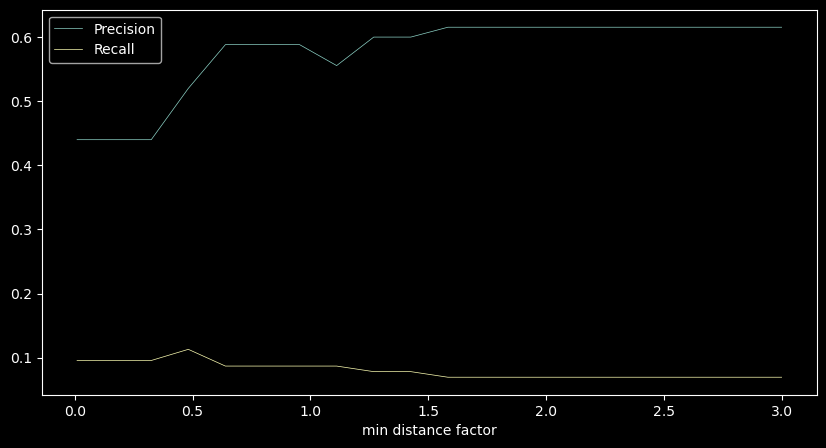

In [ ]:
reload(tools)
distance = np.linspace(0.01, 3, 20)
precision["distance"] = []
recall["distance"] = []
for dist in distance:
    grouped_frames = tools.extract_vowels(
        words,
        audio,
        Fs,
        fl=int(0.03 * Fs),
        long_frame=True,
        min_distance=dist,
    )
    starts_all, stops_all, vowels_all = tools.groupedframes_to_lists(
        grouped_frames, print_info=False
    )
    p, r = tools.score_vs_labels(
        starts_all,
        stops_all,
        labels_df,
        vowels=vowels_all,
        accept_partial=True,
        print_info=False,
    )
    precision["distance"].append(p)
    recall["distance"].append(r)

plt.figure(figsize=(10, 5))
plt.plot(distance, precision["distance"])
plt.plot(distance, recall["distance"])
plt.legend(("Precision", "Recall"))
plt.xlabel("min distance factor")

# 2D optimization

## Optimize zero-threshold and frame length together

In [ ]:
nbr = 20
zeros = np.linspace(0.1, 0.4, 20)
frames_len = np.int32(np.linspace(0.01, 0.1, 20) * Fs)
precision["zero_fl"] = np.zeros((len(zeros), len(frames_len)))
recall["zero_fl"] = np.zeros((len(zeros), len(frames_len)))

for row in range(len(zeros)):
    for col in range(len(frames_len)):
        grouped_frames = tools.extract_vowels(
            words,
            audio,
            Fs,
            fl=frames_len[col],
            add_context=False,
            long_frame=True,
            vol_thr=50,
            print_info=False,
            zero_thr=zeros[row],
            white_thr=0.8,
        )
        starts_all, stops_all, vowels_all = tools.groupedframes_to_lists(
            grouped_frames, print_info=False
        )
        p, r = tools.score_vs_labels(
            starts_all,
            stops_all,
            labels_df,
            vowels=vowels_all,
            accept_partial=True,
            print_info=False,
        )
        precision["zero_fl"][row][col] = p
        recall["zero_fl"][row][col] = r

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: divide by zero encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\peakutils\peak.py:43: RuntimeWarning: invalid value encountered in scalar add
  thres = thres * (np.max(y) - np.min(y)) + np.min(y)
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: divide by zero encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\peakutils\peak.py:43:

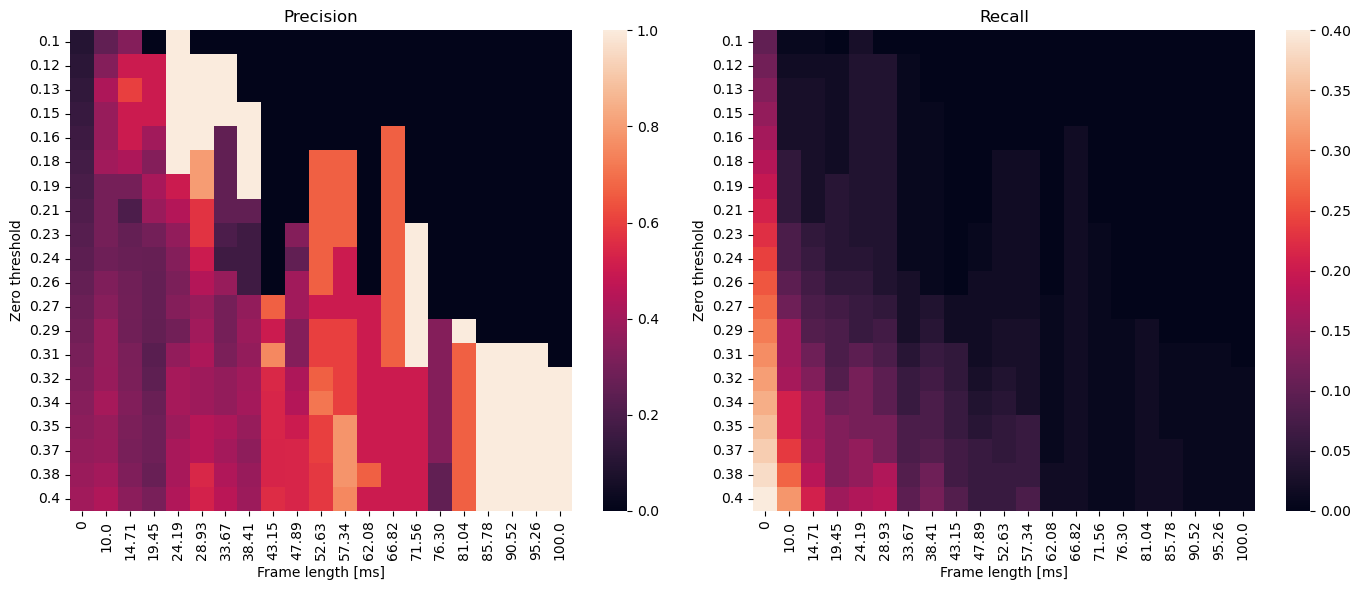

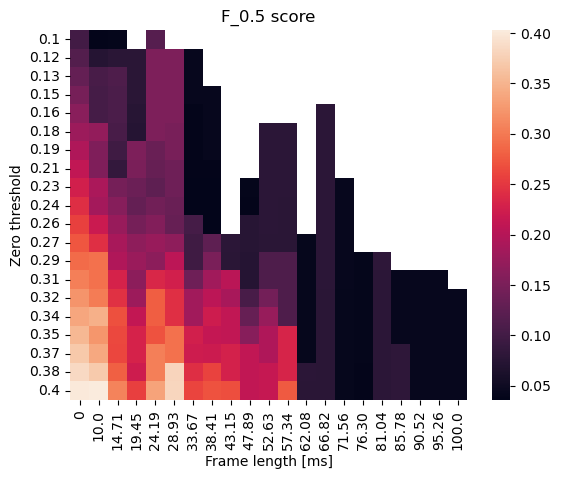

In [ ]:
# pd_precision = pd.DataFrame(
#     precision["zero_fl"], columns=frames_len / Fs * 1000, index=zeros
# )
# pd_recall = pd.DataFrame(recall["zero_fl"], columns=frames_len / Fs * 1000, index=zeros)

zeros = np.linspace(0.1, 0.4, 20)

# load and format for plotting
pd_precision = pd.read_csv("optimize/precision_matrix.csv")
pd_recall = pd.read_csv("optimize/recall_matrix.csv")
pd_precision.set_index(np.round(zeros, 2), inplace=True)
pd_recall.set_index(np.round(zeros, 2), inplace=True)
pd_precision.columns = [x[:5] for x in pd_precision.columns]
pd_recall.columns = [x[:5] for x in pd_recall.columns]

plt.style.use("default")

plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.heatmap(pd_precision, annot=False)
plt.xlabel("Frame length [ms]")
plt.ylabel("Zero threshold")
plt.title("Precision")

plt.subplot(122)
sns.heatmap(pd_recall, annot=False)
plt.xlabel("Frame length [ms]")
plt.ylabel("Zero threshold")
plt.title("Recall")
plt.tight_layout()

plt.savefig("figures/opti_pr_zt_fl_light.eps", dpi=600)
plt.show()

# pd.DataFrame.to_csv(pd_precision, "optimize/precision_matrix.csv")
# pd.DataFrame.to_csv(pd_recall, "optimize/recall_matrix.csv")


def F_beta(p, r, beta):
    return (1 + beta**2) * (p * r) / (beta**2 * p + r)


BETA = 0.5

pd_Fscore = F_beta(pd_precision, pd_recall, BETA)

plt.figure()
sns.heatmap(pd_Fscore, annot=False)
plt.xlabel("Frame length [ms]")
plt.ylabel("Zero threshold")
plt.title(f"F_{BETA} score")
plt.savefig("figures/opti_f05_zt_fl_light.eps", dpi=600)

## optimize zero thr and zero thr 2

In [ ]:
reload(tools)
nbr = 20
thrs = np.linspace(0.01, 0.9, nbr)

precision["zz"] = np.zeros((nbr, nbr))
recall["zz"] = np.zeros((nbr, nbr))

for row in range(nbr):
    for col in range(nbr):
        grouped_frames = tools.extract_vowels(
            words,
            audio,
            Fs,
            fl=int(0.03 * Fs),
            long_frame=True,
            zero_thr=thrs[row],
            zero_thr_2=thrs[col],
        )
        starts_all, stops_all, vowels_all = tools.groupedframes_to_lists(
            grouped_frames, print_info=False
        )
        p, r = tools.score_vs_labels(
            starts_all,
            stops_all,
            labels_df,
            vowels=vowels_all,
            accept_partial=True,
            print_info=False,
        )
        precision["zz"][row][col] = p
        recall["zz"][row][col] = r

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:587: RuntimeWarning: invalid value encountered in divide
  r_x /= r_x[ 0 ]
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\Signal_Analysis\features\signal.py:625: RuntimeWarning: divide by zero encountered in divide
  best_cands = 10.0 * np.log10( best_cands / ( 1.0 - best_cands ) )
c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-pac

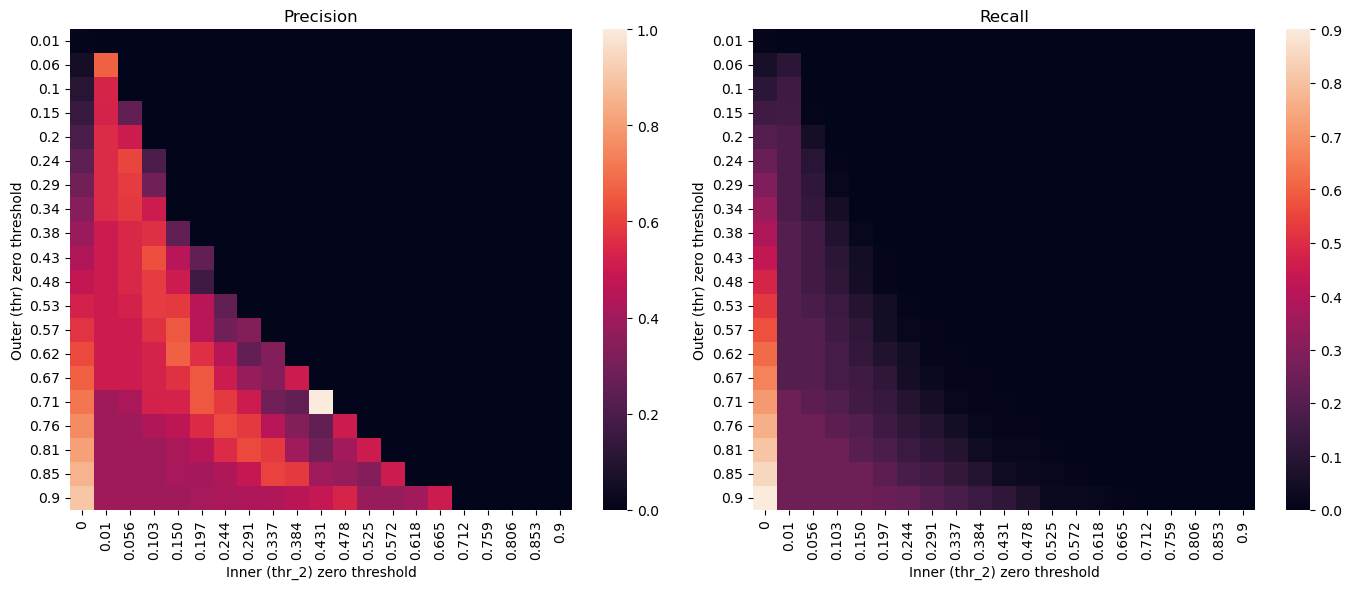

Text(0.5, 1.0, 'F_0.5 score')

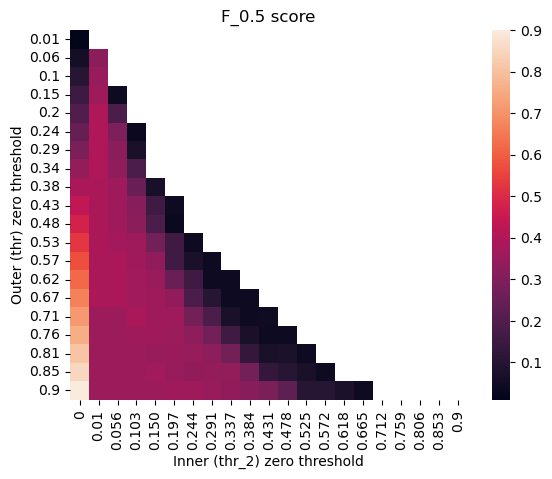

In [ ]:
# pd_precision = pd.DataFrame(precision["zz"], columns=thrs, index=thrs)
# pd_recall = pd.DataFrame(recall["zz"], columns=thrs, index=thrs)
thrs = np.linspace(0.01, 0.9, 20)

# load and format for plotting
pd_precision = pd.read_csv("optimize/precision_matrix_zz.csv")
pd_recall = pd.read_csv("optimize/recall_matrix_zz.csv")
pd_precision.set_index(np.round(thrs, 2), inplace=True)
pd_recall.set_index(np.round(thrs, 2), inplace=True)
pd_precision.columns = [x[:5] for x in pd_precision.columns]
pd_recall.columns = [x[:5] for x in pd_recall.columns]


plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.heatmap(pd_precision, annot=False)
plt.xlabel("Inner (thr_2) zero threshold")
plt.ylabel("Outer (thr) zero threshold")
plt.title("Precision")

plt.subplot(122)
sns.heatmap(pd_recall, annot=False)
plt.xlabel("Inner (thr_2) zero threshold")
plt.ylabel("Outer (thr) zero threshold")
plt.title("Recall")
plt.tight_layout()
plt.savefig("figures/opti_pr_zt1_zt2_light.eps")
plt.show()

# pd.DataFrame.to_csv(pd_precision, "optimize/precision_matrix_zz.csv")
# pd.DataFrame.to_csv(pd_recall, "optimize/recall_matrix_zz.csv")


def F_beta(p, r, beta):
    return (1 + beta**2) * (p * r) / (beta**2 * p + r)


BETA = 0.5

pd_Fscore = F_beta(pd_precision, pd_recall, BETA)

plt.figure()
sns.heatmap(pd_Fscore, annot=False)
plt.xlabel("Inner (thr_2) zero threshold")
plt.ylabel("Outer (thr) zero threshold")
plt.title(f"F_{BETA} score")